In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

!nvidia-smi

Sun Feb  6 17:43:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 470.42.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:07.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 12198MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Whole train code

In [3]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

In [1]:
import os
import random
import h5py
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from easydict import EasyDict as edict
from glob import glob
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from glob import glob
from copy import copy
from shutil import rmtree
from torch.utils import data

import monai.transforms as tf
from monai.losses import DiceLoss, DiceCELoss
from monai.networks.nets import UNet, UNETR, DynUNet
from monai.networks.layers import Norm
from monai.networks import one_hot
from monai.metrics import compute_meandice

from utils.Device import *
from utils.Data import load_dataloader


# train transforms
train_transforms = tf.Compose([
    tf.LoadImaged(reader="NibabelReader", keys=['image', 'label']),
#     tf.AsDiscreted(keys=['label'], threshold_values=True),
    tf.ToNumpyd(keys=['image', 'label']),
    tf.NormalizeIntensityd(keys=['image'], channel_wise=True, nonzero=True),
    tf.ToTensord(keys=['image', 'label']),
#         tf.DeleteItemsd(keys=['image_transforms', 'label_transforms'])
])


# validation and test transforms
val_transforms = tf.Compose([
    tf.LoadImaged(reader="NibabelReader", keys=['image', 'label']),
#     tf.AsDiscreted(keys=['label'], threshold_values=True),
    tf.ToNumpyd(keys=['image', 'label']),
    tf.NormalizeIntensityd(keys=['image'], channel_wise=True, nonzero=True),
    tf.ToTensord(keys=['image', 'label'])
])

# root_dir = "/cluster/home/kimsa/data/BraTs2020/BraTS2020_training_data/content/data_monai"
root_dir = "/cluster/projects/mcintoshgroup/BraTs2020/data_monai/"

loader_params = dict(
    batch_size=8,
    shuffle=True
)

train_dataloader = load_dataloader(root_dir, "train", train_transforms, loader_params)
valid_dataloader = load_dataloader(root_dir, "valid", val_transforms, loader_params)
test_dataloader = load_dataloader(root_dir, "test", val_transforms, loader_params)

# Logging
ckpt_save_dir = "./result/exps/unetr-debug"
os.makedirs(ckpt_save_dir, exist_ok=True)

img_save_dir = os.path.join(ckpt_save_dir, "figures")
os.makedirs(img_save_dir, exist_ok=True)

images_seqs = [f"{idx+1}" for idx in range(4)]

# Model
amp = True
device, multi_gpu = gpu_setting()
model = UNETR(in_channels=4,
              out_channels=3+1,
              img_size=240,
              feature_size=16,
              dropout_rate=0.3,
              norm_name='batch',
              spatial_dims=2).to(device)
model = model_dataparallel(model, multi_gpu)


# Loss function
loss_function = DiceCELoss(
    include_background=False,
    to_onehot_y=False,
    squared_pred=True,
    softmax=True,
    lambda_dice=0.3,
    lambda_ce=0.7
)

softmax = torch.nn.Softmax(dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scaler = torch.cuda.amp.GradScaler() if amp else None
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.95, patience=10)
num_epochs = 4
val_freq = 2

train_losses = list()
val_losses = list()

best_loss = 1e+2
for epoch in range(num_epochs):
    
    current_lr = optimizer.param_groups[0]['lr']
    
    batch_loss = dict(
        train=0,
        val=0
    )
    batch_dice = dict(
        train=0,
        val=0
    )
    total_num_imgs = dict(
        train=0,
        val=0
    )
    
    model.train()
    
    for batch_idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        inputs, labels = batch["image"], batch["label"]
        labels = one_hot(labels.argmax(1).unsqueeze(1), num_classes=4)  # make one-hot
        inputs, labels = inputs.to(device), labels.to(device)

        if amp and scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
        batch_loss['train'] += float(loss.data) * inputs.size(0)
        total_num_imgs['train'] += inputs.size(0)
        
    # validation
    model.eval()
    with torch.no_grad():
        for batch in valid_dataloader:
            inputs, labels = batch["image"], batch["label"]
            labels = one_hot(labels.argmax(1).unsqueeze(1), num_classes=4)  # make one-hot
            inputs, labels = inputs.to(device), labels.to(device)

            if amp and scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
            
            batch_dice['val'] += compute_meandice(outputs, labels, include_background=False).nanmean() * inputs.size(0)
            batch_loss['val'] += float(loss.data) * inputs.size(0)
            total_num_imgs['val'] += inputs.size(0)
    
    batch_loss['train'] = batch_loss['train'] / total_num_imgs['train']
    batch_loss['val'] = batch_loss['val'] / total_num_imgs['val']
    batch_dice['val'] = batch_dice['val'] / total_num_imgs['val']
    
    train_losses.append(batch_loss['train'])
    val_losses.append(batch_loss['val'])
    scheduler.step(batch_loss['val'])
    
    # print if scheduler changes current lr
    if optimizer.param_groups[0]['lr'] != current_lr:
        print(f"Learning Rate Changed {current_lr:.4f} --> {optimizer.param_groups[0]['lr']:.4f}")
        
    torch.save(model.state_dict(), os.path.join(ckpt_save_dir, "checkpoint.pth"))
    if best_loss >= batch_loss['val']:
        best_loss = batch_loss['val']
        torch.save(model.state_dict(), os.path.join(ckpt_save_dir, "best.pth"))

    print(f"Epoch [{epoch+1}/{num_epochs}]  Train loss: {batch_loss['train']:.4f} Val loss: {batch_loss['val']:.4f} Val Dice: {batch_dice['val']:.4f} (best loss: {best_loss:.4f}) lr: {optimizer.param_groups[0]['lr']:.4f}")

    # Visualization
    outputs = softmax(outputs)
    tr = 0.5
    
    output_image = outputs.detach().cpu().numpy()
    output_image_tr = np.where(output_image > tr, 1, 0)

    loaded_image = inputs.detach().cpu().numpy()
    loaded_label = labels.detach().cpu().numpy()
    
    for img_idx in range(inputs.size(0)):
        fig, axes = plt.subplots(2, inputs.size(1), figsize=(20, 10))
        plt.suptitle(f"Epoch {epoch+1}", y=0.95)
        for img_seq_idx in range(inputs.size(1)):
            loaded_seq_image = loaded_image[img_idx][img_seq_idx].squeeze()
            axes[0, img_seq_idx].imshow(loaded_seq_image, cmap='gray',
                                        vmin=loaded_seq_image.mean() - loaded_seq_image.std() * 1.96,
                                        vmax=loaded_seq_image.mean() + loaded_seq_image.std() * 1.96)
            axes[0, img_seq_idx].set_title(f"Input ({images_seqs[img_seq_idx]})")
        axes[1, 0].imshow(loaded_label[img_idx].argmax(0).squeeze(), cmap='gray')
        axes[1, 0].set_title("Label")
        axes[1, 1].imshow(output_image_tr[img_idx].argmax(0).squeeze(), cmap='gray')
        axes[1, 1].set_title("Output")
        fig.delaxes(axes[1, 2])
        fig.delaxes(axes[1, 3])
        plt.savefig(os.path.join(img_save_dir, f"epoch-{epoch+1}_loss_{batch_loss['val']:.4f}.jpg"), bbox_inches='tight', dpi=100)
        plt.show()
        plt.close()
#         break
#     break

    
# Test
test_dice = 0
total_num_imgs = 0

model.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        inputs, labels = batch["image"], batch["label"]
        labels = one_hot(labels.argmax(1).unsqueeze(1), num_classes=4)  # make one-hot
        inputs, labels = inputs.to(device), labels.to(device)

        if amp and scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
        else:
            outputs = model(inputs)

        test_dice += compute_meandice(outputs, labels, include_background=False).nanmean() * inputs.size(0)
        total_num_imgs += inputs.size(0)
        
        # Visualization
        outputs = softmax(outputs)
        tr = 0.5

        output_image = outputs.detach().cpu().numpy()
        output_image_tr = np.where(output_image > tr, 1, 0)

        loaded_image = inputs.detach().cpu().numpy()
        loaded_label = labels.detach().cpu().numpy()

        for img_idx in range(inputs.size(0)):
            fig, axes = plt.subplots(2, inputs.size(1), figsize=(20, 10))
            plt.suptitle(f"Test {batch_idx+1}", y=0.95)
            for img_seq_idx in range(inputs.size(1)):
                loaded_seq_image = loaded_image[img_idx][img_seq_idx].squeeze()
                axes[0, img_seq_idx].imshow(loaded_seq_image, cmap='gray',
                                            vmin=loaded_seq_image.mean() - loaded_seq_image.std() * 1.96,
                                            vmax=loaded_seq_image.mean() + loaded_seq_image.std() * 1.96)
                axes[0, img_seq_idx].set_title(f"Input ({images_seqs[img_seq_idx]})")
            axes[1, 0].imshow(loaded_label[img_idx].argmax(0).squeeze(), cmap='gray')
            axes[1, 0].set_title("Label")
            axes[1, 1].imshow(output_image_tr[img_idx].argmax(0).squeeze(), cmap='gray')
            axes[1, 1].set_title("Output")
            fig.delaxes(axes[1, 2])
            fig.delaxes(axes[1, 3])
            plt.savefig(os.path.join(img_save_dir, f"test-{batch_idx+1}.jpg"), bbox_inches='tight', dpi=100)
            plt.show()
            plt.close()
            break
        
test_dice /= total_num_imgs
print(f"Test Dice: {test_dice:.4f}")

# rmtree(ckpt_save_dir)


ModuleNotFoundError: No module named 'utils'

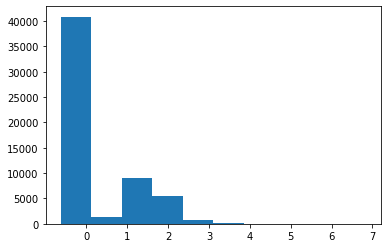

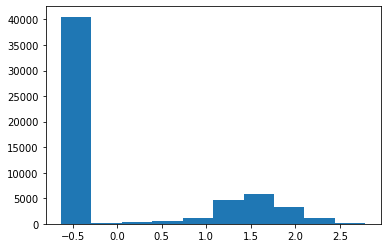

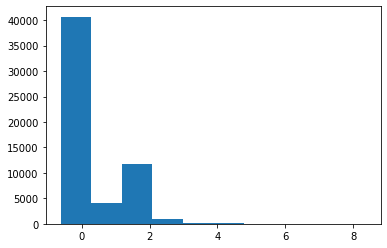

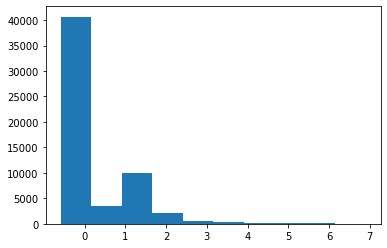

In [58]:
for b in range(inputs.size(0)):
    input_image = inputs[b].detach().cpu().numpy()
    for seq_idx in range(input_image.shape[0]):
        plt.hist(input_image[seq_idx].flatten())
        plt.show()
        plt.close()
    break

In [56]:
inputs.size(), labels.size()

(torch.Size([8, 4, 240, 240]), torch.Size([8, 4, 240, 240]))

In [46]:
loss_function = DiceCELoss(
    include_background=False,
    to_onehot_y=False,
    squared_pred=False,
    softmax=False,
    lambda_dice=0.3,
    lambda_ce=0.7,
    reduction="mean"
)


softmax = nn.Softmax(1)
model.train()
for batch_idx, batch in enumerate(train_dataloader):
    inputs, labels = batch["image"], batch["label"]
    labels = one_hot(labels.argmax(1).unsqueeze(1), num_classes=4)  # make one-hot
    inputs, labels = inputs.to(device), labels.to(device)

    if amp and scaler is not None:
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
#             loss = loss_function(softmax(outputs), labels)
            loss = loss_function(softmax(outputs), softmax(outputs))
            print(loss)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    break

tensor(nan, device='cuda:0', grad_fn=<AddBackward0>)


In [54]:
torch.isnan(softmax(outputs)).all()

tensor(True, device='cuda:0')

/cluster/home/kimsa/anaconda3/envs/torch38/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6731: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/cluster/home/kimsa/anaconda3/envs/torch38/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6732: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))


ValueError: autodetected range of [nan, nan] is not finite

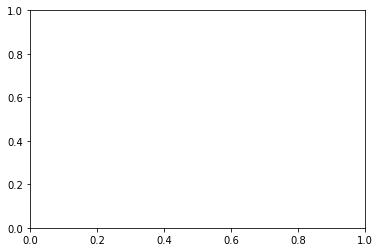

In [51]:
plt.hist(softmax(outputs)[0].detach().cpu().numpy().flatten())

(8, 4, 240, 240) (8, 4, 240, 240)


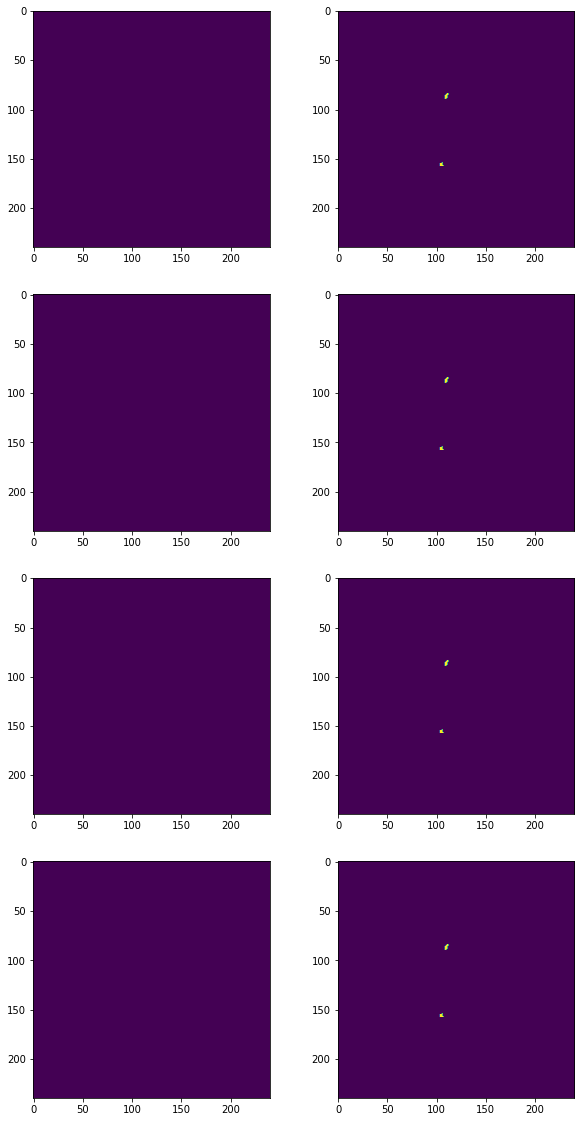

In [19]:
outputs_np = outputs.detach().cpu().numpy()
labels_np = labels.detach().cpu().numpy()

for i in range(outputs_np.shape[0]):
    single_output = outputs_np[i]
    single_label = labels_np[i]
    
    fig, axes = plt.subplots(4, 2, figsize=(10, 20))
    for j in range(4):
        axes[j, 0].imshow(single_output.argmax(0))
        axes[j, 1].imshow(single_label.argmax(0))
    break

In [10]:
val_losses

[nan, nan, nan, nan]

In [5]:
train_losses

[nan, nan, nan, nan]

In [21]:
import numpy as np
import os

from glob import glob

root_dir = "/cluster/projects/mcintoshgroup/BraTs2020/data_monai/image"
root_list = sorted(glob(os.path.join(root_dir, "*.nii.gz")))

num_train = 260  # 70%, 40300 slices
num_valid = 40 # 10% 6200 slices
num_test = 69 # 20% 10695 slices

get_volume_name = lambda x: os.path.basename(x).split("_slice")[0]
sort_key = lambda x: int(x.split('_')[-1])
unique_volumes = sorted(np.unique([get_volume_name(x) for x in root_list]), key=sort_key)

train_subjects, valid_subjects, test_subjects = unique_volumes[:num_train], unique_volumes[num_train:num_train+num_valid], unique_volumes[num_train+num_valid:]

train_list = [x for x in root_list if get_volume_name(x) in train_subjects]
valid_list = [x for x in root_list if get_volume_name(x) in valid_subjects]
test_list = [x for x in root_list if get_volume_name(x) in test_subjects]

print(f"Train: {len(train_list)}")
print(f"Valid: {len(valid_list)}")
print(f"Test: {len(test_list)}")

Train: 40300
Valid: 6200
Test: 10695


Epoch [1/2]  Train loss: 1.1341 Val loss: 1.1558 Val Dice: -0.0152 (best loss: 1.1558) lr: 0.0100


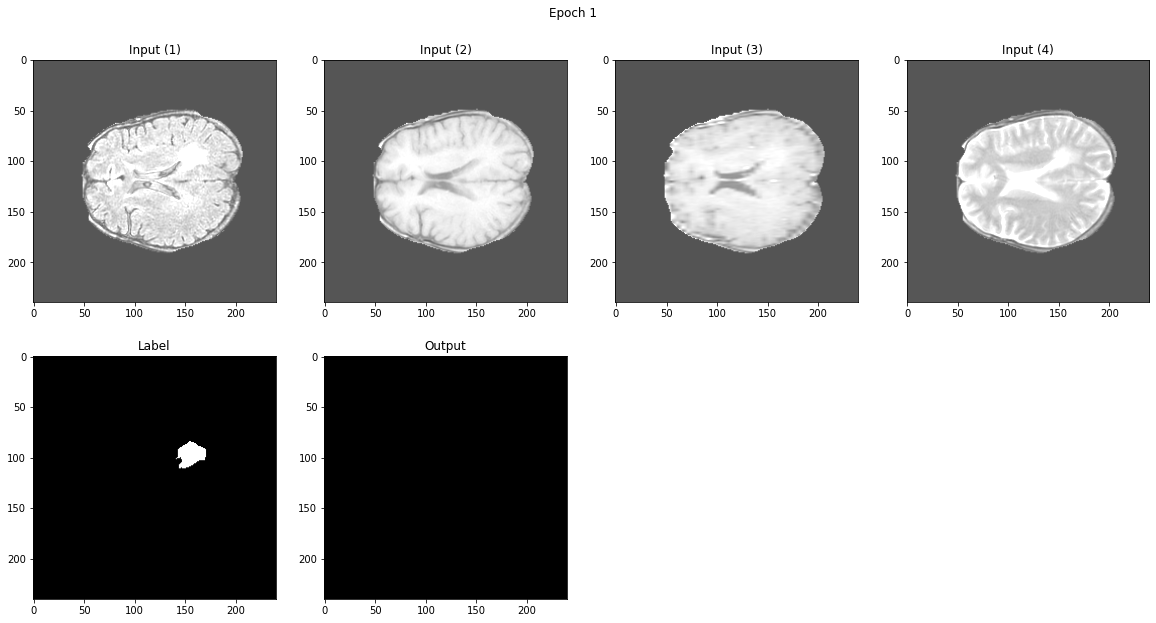

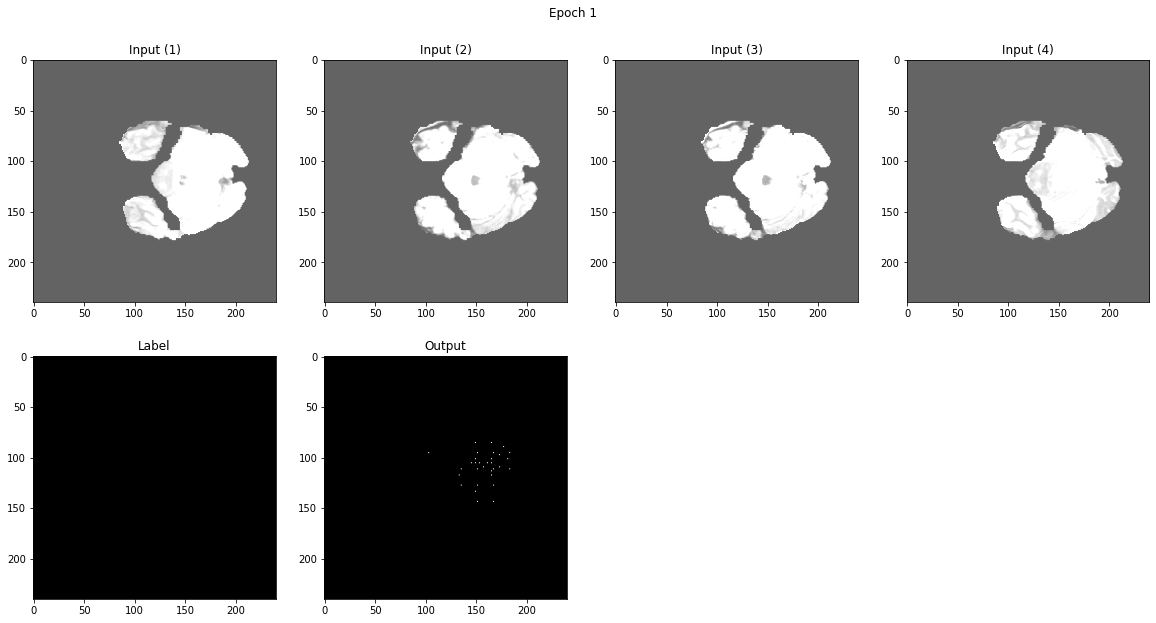

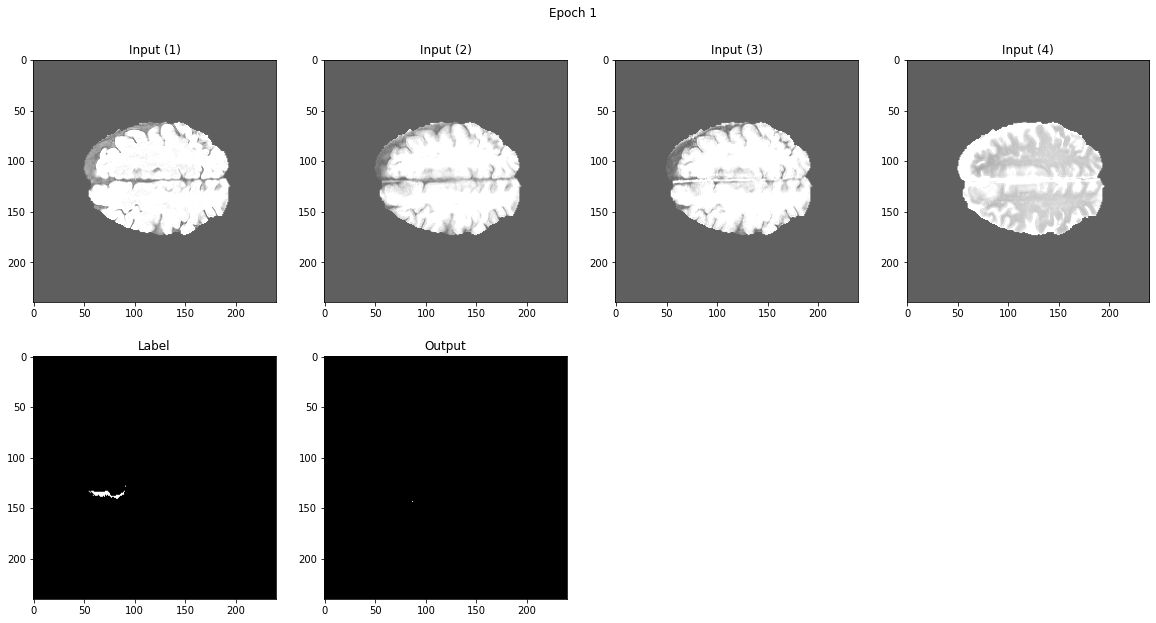

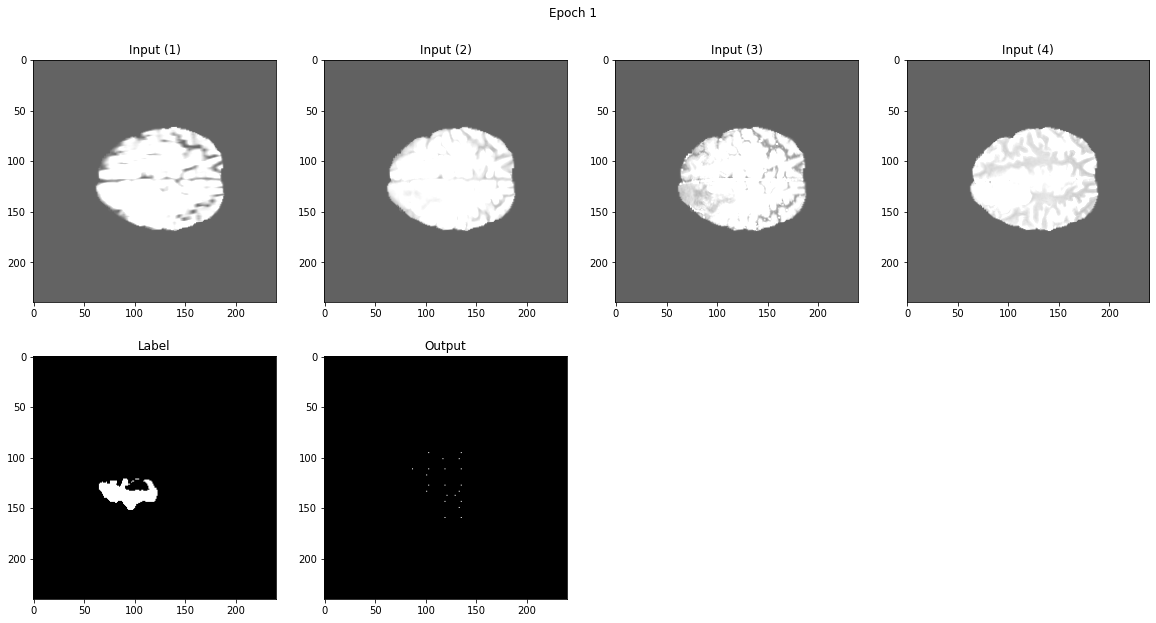

Epoch [2/2]  Train loss: 0.9533 Val loss: 0.9398 Val Dice: 0.0703 (best loss: 0.9398) lr: 0.0100


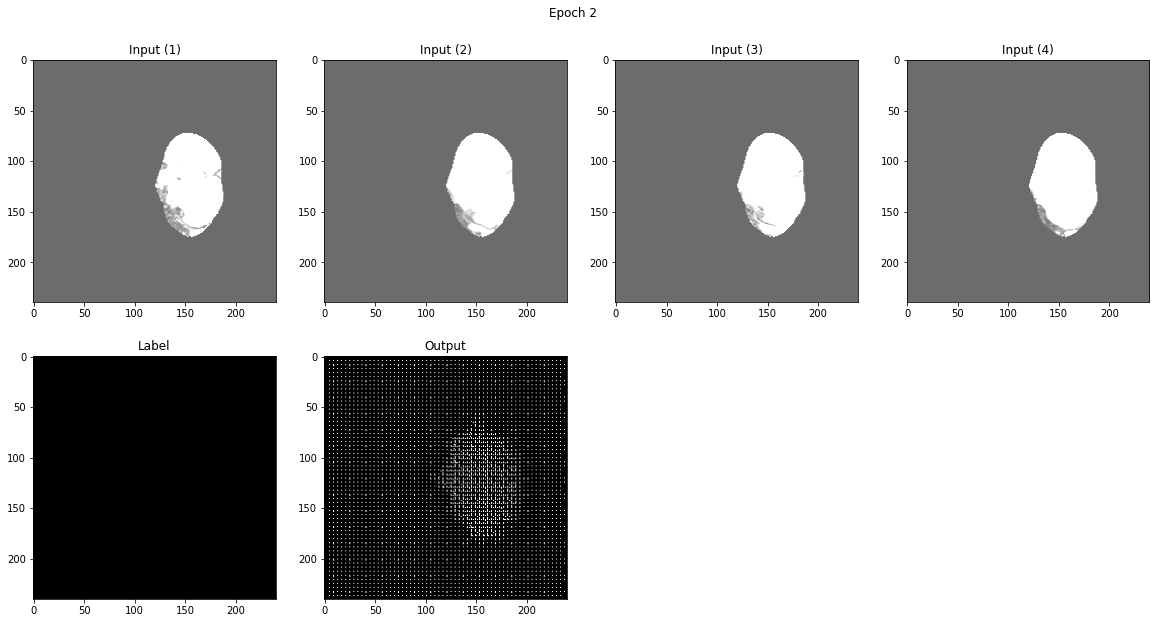

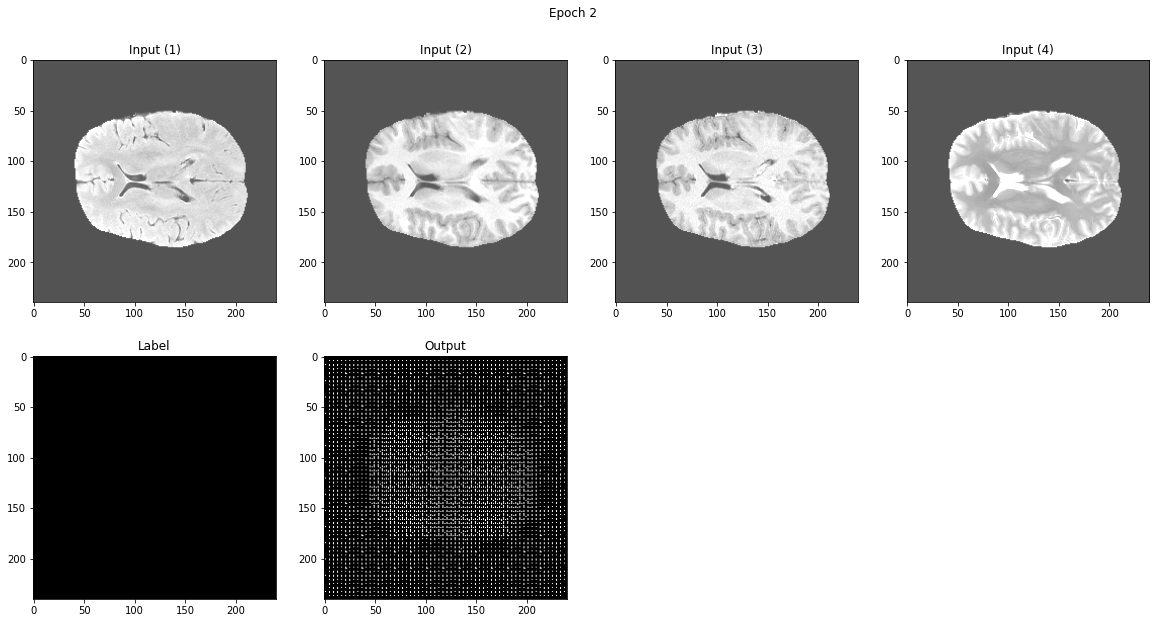

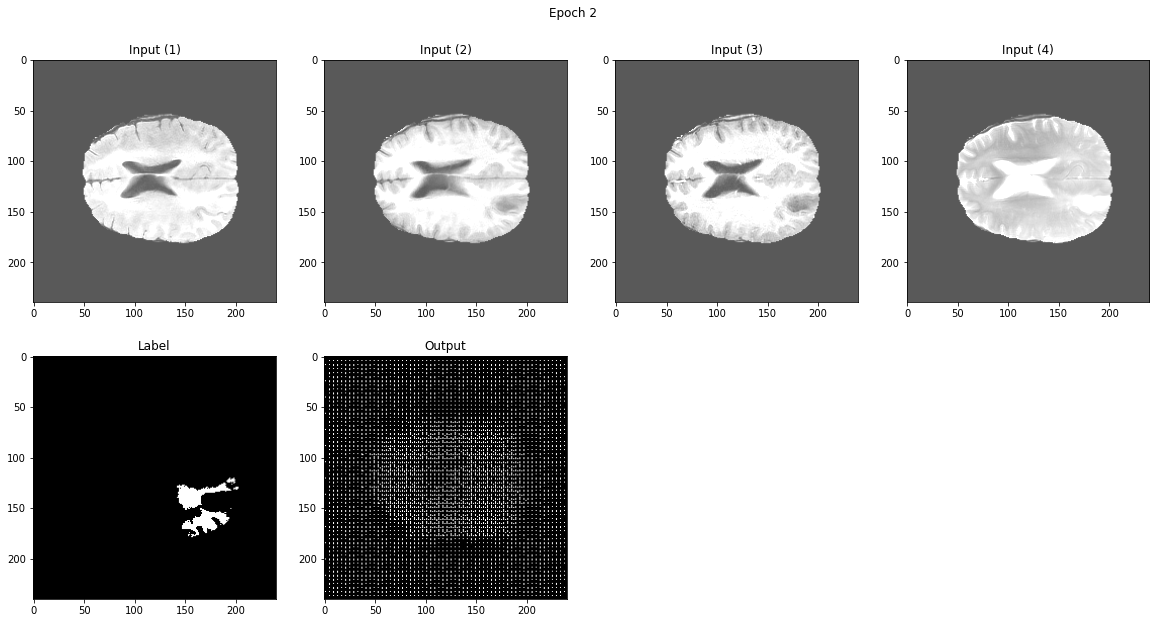

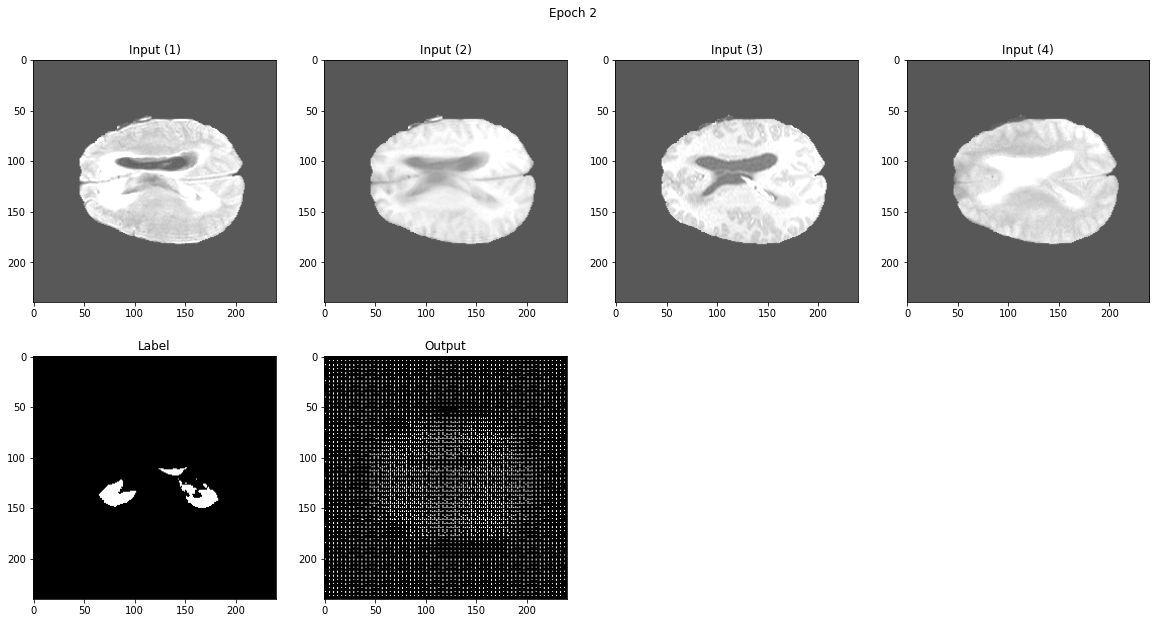

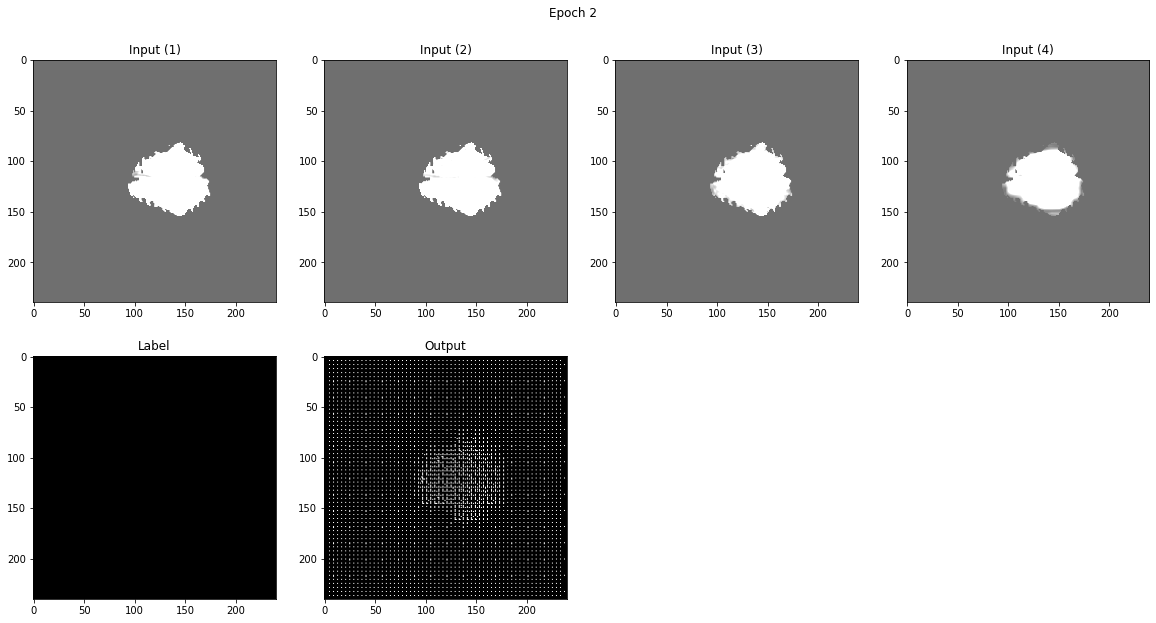

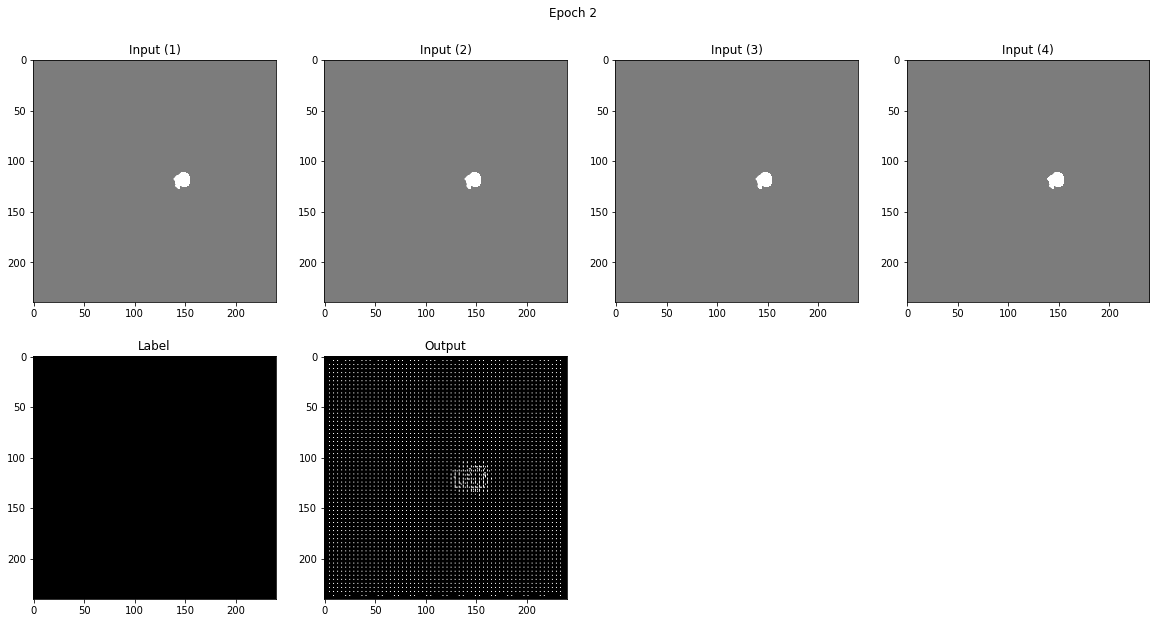

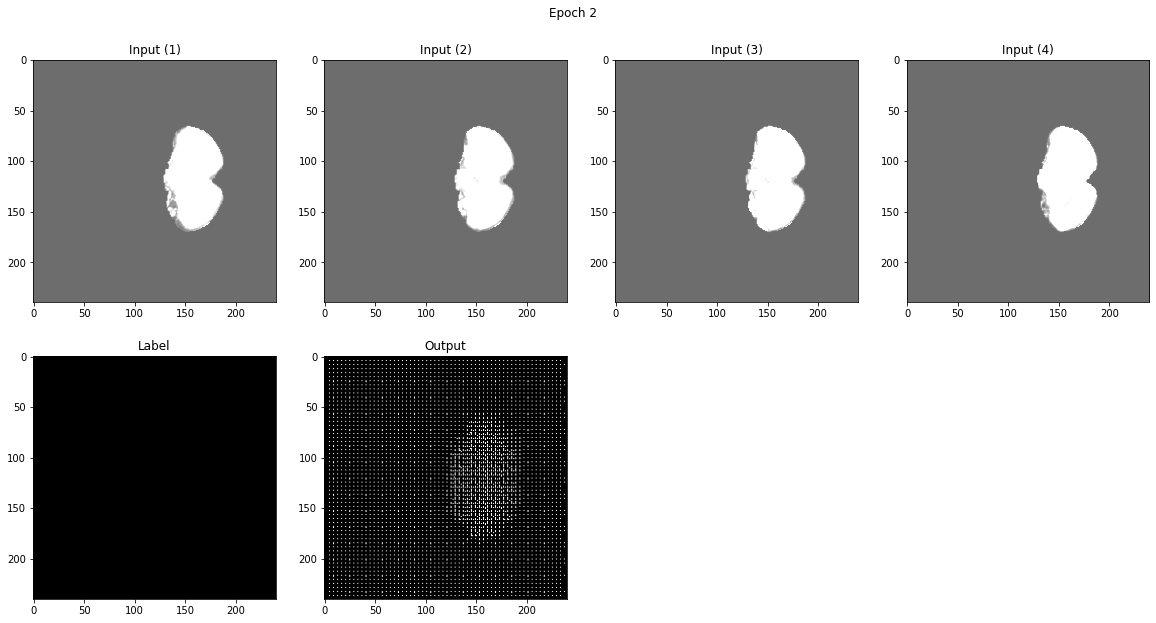

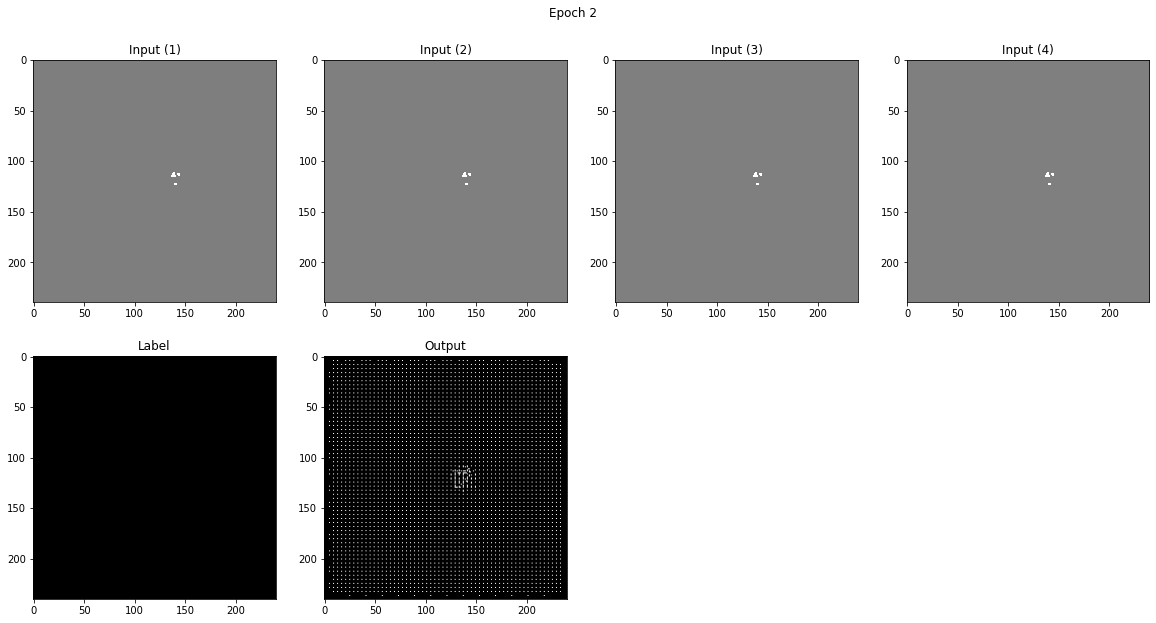

Test Dice: nan


In [2]:
import os
import random
import h5py
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt

from easydict import EasyDict as edict
from glob import glob
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
%matplotlib inline

from glob import glob
from copy import copy
from shutil import rmtree
from torch.utils import data

import monai.transforms as tf
from monai.losses import DiceLoss, DiceCELoss
from monai.networks.nets import UNet, UNETR, DynUNet
from monai.networks.layers import Norm
from monai.networks import one_hot
from monai.data import CacheDataset, ZipDataset, DataLoader, Dataset, decollate_batch
from monai.metrics import compute_meandice


def load_dataloader(root_dir, phase, transforms, dataloader_params):
    """Return dataloader
    
        -------
        root_dir = "/cluster/home/kimsa/data/BraTs2020/BraTS2020_training_data/content/data_monai"
    
        -------
        Examples
        
        for batch_idx, batch in enumerate(train_dataloader):
            image, label = batch["image"], batch["label"]
    """
    num_train = 260  # 70%, 40300 slices
    num_valid = 40 # 10% 6200 slices
    num_test = 69 # 20% 10695 slices
    
    image_list = sorted(glob(os.path.join(root_dir, "image", "*.nii.gz")))
    label_list = sorted(glob(os.path.join(root_dir, "label", "*.nii.gz")))
    
    get_volume_name = lambda x: os.path.basename(x).split("_slice")[0]
    sort_key = lambda x: int(x.split('_')[-1])
    unique_volumes = sorted(np.unique([get_volume_name(x) for x in image_list]), key=sort_key)

    train_subjects, valid_subjects, test_subjects = unique_volumes[:num_train], unique_volumes[num_train:num_train+num_valid], unique_volumes[num_train+num_valid:]
    
#     print(f"Train: {len(train_subjects)}")
#     print(f"Valid: {len(valid_subjects)}")
#     print(f"Test: {len(test_subjects)}")
    
    if phase == "train":
        train_imgs = [x for x in image_list if get_volume_name(x) in train_subjects]
        train_lbls = [x for x in label_list if get_volume_name(x) in train_subjects]
        train_list = [
            {'image': image_name, 'label': label_name}
            for image_name, label_name in zip(train_imgs, train_lbls)
        ]
        file_list = train_list
        
    elif phase == "valid":
        valid_imgs = [x for x in image_list if get_volume_name(x) in valid_subjects]
        valid_lbls = [x for x in label_list if get_volume_name(x) in valid_subjects]
        valid_list = [
            {'image': image_name, 'label': label_name}
            for image_name, label_name in zip(valid_imgs, valid_lbls)
        ]
        file_list = valid_list
        
    elif phase == "test":
        test_imgs = [x for x in image_list if get_volume_name(x) in test_subjects]
        test_lbls = [x for x in label_list if get_volume_name(x) in test_subjects]
        test_list = [
            {'image': image_name, 'label': label_name}
            for image_name, label_name in zip(test_imgs, test_lbls)
        ]
        file_list = test_list

    dataset = Dataset(data=file_list, transform=transforms)
    dataloader = DataLoader(dataset, **dataloader_params)

    return dataloader


# train transforms
train_transforms = tf.Compose([
    tf.LoadImaged(reader="NibabelReader", keys=['image', 'label']),
    tf.AsDiscreted(keys=['label'], threshold_values=True),
    tf.ToNumpyd(keys=['image', 'label']),
    tf.NormalizeIntensityd(keys=['image'], channel_wise=True, nonzero=True),
    tf.ToTensord(keys=['image', 'label']),
#         tf.DeleteItemsd(keys=['image_transforms', 'label_transforms'])
])


# validation and test transforms
val_transforms = tf.Compose([
    tf.LoadImaged(reader="NibabelReader", keys=['image', 'label']),
    tf.AsDiscreted(keys=['label'], threshold_values=True),
    tf.ToNumpyd(keys=['image', 'label']),
    tf.NormalizeIntensityd(keys=['image'], channel_wise=True, nonzero=True),
    tf.ToTensord(keys=['image', 'label'])
])

# root_dir = "/cluster/home/kimsa/data/BraTs2020/BraTS2020_training_data/content/data_monai"
root_dir = "/cluster/projects/mcintoshgroup/BraTs2020/data_monai/"

loader_params = dict(
    batch_size=4,
    shuffle=True
)

train_dataloader = load_dataloader(root_dir, "train", train_transforms, loader_params)
valid_dataloader = load_dataloader(root_dir, "valid", val_transforms, loader_params)
test_dataloader = load_dataloader(root_dir, "test", val_transforms, loader_params)

# Logging
img_save_dir = "../asset/exps/unetr-demo/figures"
ckpt_save_dir = "../asset/exps/unetr-demo"
os.makedirs(img_save_dir, exist_ok=True)
os.makedirs(ckpt_save_dir, exist_ok=True)

images_seqs = [f"{idx+1}" for idx in range(4)]

# Model
amp = True
device = torch.device("cuda:0") if torch.cuda.is_available() else "cpu"

model = UNETR(in_channels=4,
              out_channels=3+1,
              img_size=240,
              feature_size=8,
              dropout_rate=0.3,
              norm_name='batch',
              spatial_dims=2).to(device)


# Loss function
loss_function = DiceCELoss(
    include_background=False,
    to_onehot_y=False,
    squared_pred=True,
    softmax=True,
    lambda_dice=0.3,
    lambda_ce=0.7
)

softmax = torch.nn.Softmax(dim=1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scaler = torch.cuda.amp.GradScaler() if amp else None
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.9, patience=10)
num_epochs = 2
val_freq = 2

train_losses = list()
val_losses = list()

best_loss = 1e+2
for epoch in range(num_epochs):
    
    current_lr = optimizer.param_groups[0]['lr']
    
    batch_loss = dict(
        train=0,
        val=0
    )
    batch_dice = dict(
        train=0,
        val=0
    )
    total_num_imgs = dict(
        train=0,
        val=0
    )
    
    model.train()
    
    for batch_idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        inputs, labels = batch["image"], batch["label"]
        labels = one_hot(labels.argmax(1).unsqueeze(1), num_classes=4)  # make one-hot
        inputs, labels = inputs.to(device), labels.to(device)

        if amp and scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
        batch_loss['train'] += float(loss.data) * inputs.size(0)
        total_num_imgs['train'] += inputs.size(0)
        
        break
        
    # validation
    model.eval()
    with torch.no_grad():
        for batch in valid_dataloader:
            inputs, labels = batch["image"], batch["label"]
            labels = one_hot(labels.argmax(1).unsqueeze(1), num_classes=4)  # make one-hot
            inputs, labels = inputs.to(device), labels.to(device)

            if amp and scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)
            
            batch_dice['val'] += compute_meandice(outputs, labels, include_background=False).nanmean() * inputs.size(0)
            batch_loss['val'] += float(loss.data) * inputs.size(0)
            total_num_imgs['val'] += inputs.size(0)
            
            break
    
    batch_loss['train'] = batch_loss['train'] / total_num_imgs['train']
    batch_loss['val'] = batch_loss['val'] / total_num_imgs['val']
    batch_dice['val'] = batch_dice['val'] / total_num_imgs['val']
    
    train_losses.append(batch_loss['train'])
    val_losses.append(batch_loss['val'])
    scheduler.step(batch_loss['val'])
    
    # print if scheduler changes current lr
    if optimizer.param_groups[0]['lr'] != current_lr:
        print(f"Learning Rate Changed {current_lr:.4f} --> {optimizer.param_groups[0]['lr']:.4f}")
        
    torch.save(model.state_dict(), os.path.join(ckpt_save_dir, "checkpoint.pth"))
    if best_loss >= batch_loss['val']:
        best_loss = batch_loss['val']
        torch.save(model.state_dict(), os.path.join(ckpt_save_dir, "best.pth"))

    print(f"Epoch [{epoch+1}/{num_epochs}]  Train loss: {batch_loss['train']:.4f} Val loss: {batch_loss['val']:.4f} Val Dice: {batch_dice['val']:.4f} (best loss: {best_loss:.4f}) lr: {optimizer.param_groups[0]['lr']:.4f}")

    # Visualization
    outputs = softmax(outputs)
    tr = 0.5
    
    output_image = outputs.detach().cpu().numpy()
    output_image_tr = np.where(output_image > tr, 1, 0)

    loaded_image = inputs.detach().cpu().numpy()
    loaded_label = labels.detach().cpu().numpy()
    
    for img_idx in range(inputs.size(0)):
        fig, axes = plt.subplots(2, inputs.size(1), figsize=(20, 10))
        plt.suptitle(f"Epoch {epoch+1}", y=0.95)
        for img_seq_idx in range(inputs.size(1)):
            loaded_seq_image = loaded_image[img_idx][img_seq_idx].squeeze()
            axes[0, img_seq_idx].imshow(loaded_seq_image, cmap='gray',
                                        vmin=loaded_seq_image.mean() - loaded_seq_image.std() * 1.96,
                                        vmax=loaded_seq_image.mean() + loaded_seq_image.std() * 1.96)
            axes[0, img_seq_idx].set_title(f"Input ({images_seqs[img_seq_idx]})")
        axes[1, 0].imshow(loaded_label[img_idx].argmax(0).squeeze(), cmap='gray')
        axes[1, 0].set_title("Label")
        axes[1, 1].imshow(output_image_tr[img_idx].argmax(0).squeeze(), cmap='gray')
        axes[1, 1].set_title("Output")
        fig.delaxes(axes[1, 2])
        fig.delaxes(axes[1, 3])
#         plt.savefig(os.path.join(img_save_dir, f"epoch-{epoch+1}_loss_{batch_loss['val']:.4f}.jpg"), bbox_inches='tight', dpi=100)
        plt.show()
        plt.close()
#         break
#     break

    
# Test
test_dice = 0
total_num_imgs = 0

model.eval()
with torch.no_grad():
    for batch_idx, batch in enumerate(test_dataloader):
        inputs, labels = batch["image"], batch["label"]
        labels = one_hot(labels.argmax(1).unsqueeze(1), num_classes=4)  # make one-hot
        inputs, labels = inputs.to(device), labels.to(device)

        if amp and scaler is not None:
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
        else:
            outputs = model(inputs)

        test_dice += compute_meandice(outputs, labels, include_background=False).nanmean() * inputs.size(0)
        total_num_imgs += inputs.size(0)
        
        # Visualization
        outputs = softmax(outputs)
        tr = 0.5

        output_image = outputs.detach().cpu().numpy()
        output_image_tr = np.where(output_image > tr, 1, 0)

        loaded_image = inputs.detach().cpu().numpy()
        loaded_label = labels.detach().cpu().numpy()

        for img_idx in range(inputs.size(0)):
            fig, axes = plt.subplots(2, inputs.size(1), figsize=(20, 10))
            plt.suptitle(f"Epoch {epoch+1}", y=0.95)
            for img_seq_idx in range(inputs.size(1)):
                loaded_seq_image = loaded_image[img_idx][img_seq_idx].squeeze()
                axes[0, img_seq_idx].imshow(loaded_seq_image, cmap='gray',
                                            vmin=loaded_seq_image.mean() - loaded_seq_image.std() * 1.96,
                                            vmax=loaded_seq_image.mean() + loaded_seq_image.std() * 1.96)
                axes[0, img_seq_idx].set_title(f"Input ({images_seqs[img_seq_idx]})")
            axes[1, 0].imshow(loaded_label[img_idx].argmax(0).squeeze(), cmap='gray')
            axes[1, 0].set_title("Label")
            axes[1, 1].imshow(output_image_tr[img_idx].argmax(0).squeeze(), cmap='gray')
            axes[1, 1].set_title("Output")
            fig.delaxes(axes[1, 2])
            fig.delaxes(axes[1, 3])
            plt.savefig(os.path.join(img_save_dir, f"test-{batch_idx+1}.jpg"), bbox_inches='tight', dpi=100)
            plt.show()
            plt.close()
            
        break
        
test_dice /= total_num_imgs
print(f"Test Dice: {test_dice:.4f}")

# rmtree(ckpt_save_dir)


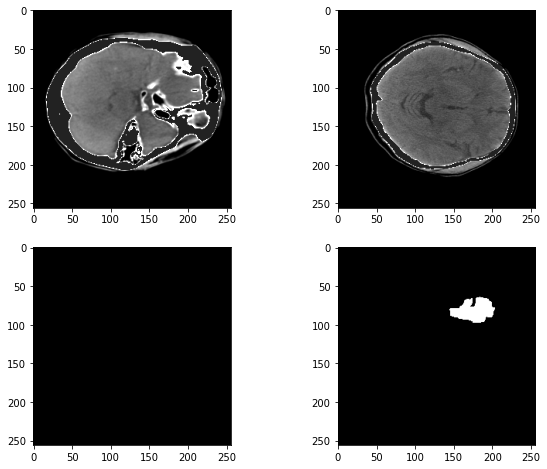

In [23]:
# Visualization
threshold = 150
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes[0, 0].imshow(np.where(loaded_image[0] > 250, 0, loaded_image[0]).squeeze(), cmap='gray', vmax=threshold)
axes[0, 1].imshow(np.where(loaded_image[1] > 250, 0, loaded_image[1]).squeeze(), cmap='gray', vmax=threshold)
axes[1, 0].imshow(loaded_label[0].squeeze(), cmap='gray')
axes[1, 1].imshow(loaded_label[1].squeeze(), cmap='gray')
plt.show()
plt.close()
